In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import struct

import warnings
warnings.filterwarnings('ignore')


2025-12-10 09:02:10.662435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765357330.863892      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765357330.917541      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
print("Loading Arabic Dataset...")
X_train_arabic = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv", header=None)
Y_train_arabic = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv", header=None)
X_test_arabic = pd.read_csv(r"/kaggle/input/ahcd1/csvTestImages 3360x1024.csv", header=None)
Y_test_arabic = pd.read_csv(r"/kaggle/input/ahcd1/csvTestLabel 3360x1.csv", header=None)

print("Arabic Dataset Shapes:")
print(f"X_train_arabic: {X_train_arabic.shape}")
print(f"Y_train_arabic: {Y_train_arabic.shape}")
print(f"X_test_arabic: {X_test_arabic.shape}")
print(f"Y_test_arabic: {Y_test_arabic.shape}")


Loading Arabic Dataset...
Arabic Dataset Shapes:
X_train_arabic: (13440, 1024)
Y_train_arabic: (13440, 1)
X_test_arabic: (3360, 1024)
Y_test_arabic: (3360, 1)


In [3]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

print("\nLoading English Dataset...")
train_images_path = r"/kaggle/input/emnist/emnist_source_files/emnist-letters-train-images-idx3-ubyte"
train_labels_path = r"/kaggle/input/emnist/emnist_source_files/emnist-letters-train-labels-idx1-ubyte"
test_images_path = r"/kaggle/input/emnist/emnist_source_files/emnist-letters-test-images-idx3-ubyte"
test_labels_path = r"/kaggle/input/emnist/emnist_source_files/emnist-letters-test-labels-idx1-ubyte"

x_train_english = read_idx(train_images_path)
y_train_english = read_idx(train_labels_path)
x_test_english = read_idx(test_images_path)
y_test_english = read_idx(test_labels_path)

print("English Dataset Shapes:")
print(f"x_train_english: {x_train_english.shape}")
print(f"y_train_english: {y_train_english.shape}")
print(f"x_test_english: {x_test_english.shape}")
print(f"y_test_english: {y_test_english.shape}")


Loading English Dataset...
English Dataset Shapes:
x_train_english: (124800, 28, 28)
y_train_english: (124800,)
x_test_english: (20800, 28, 28)
y_test_english: (20800,)


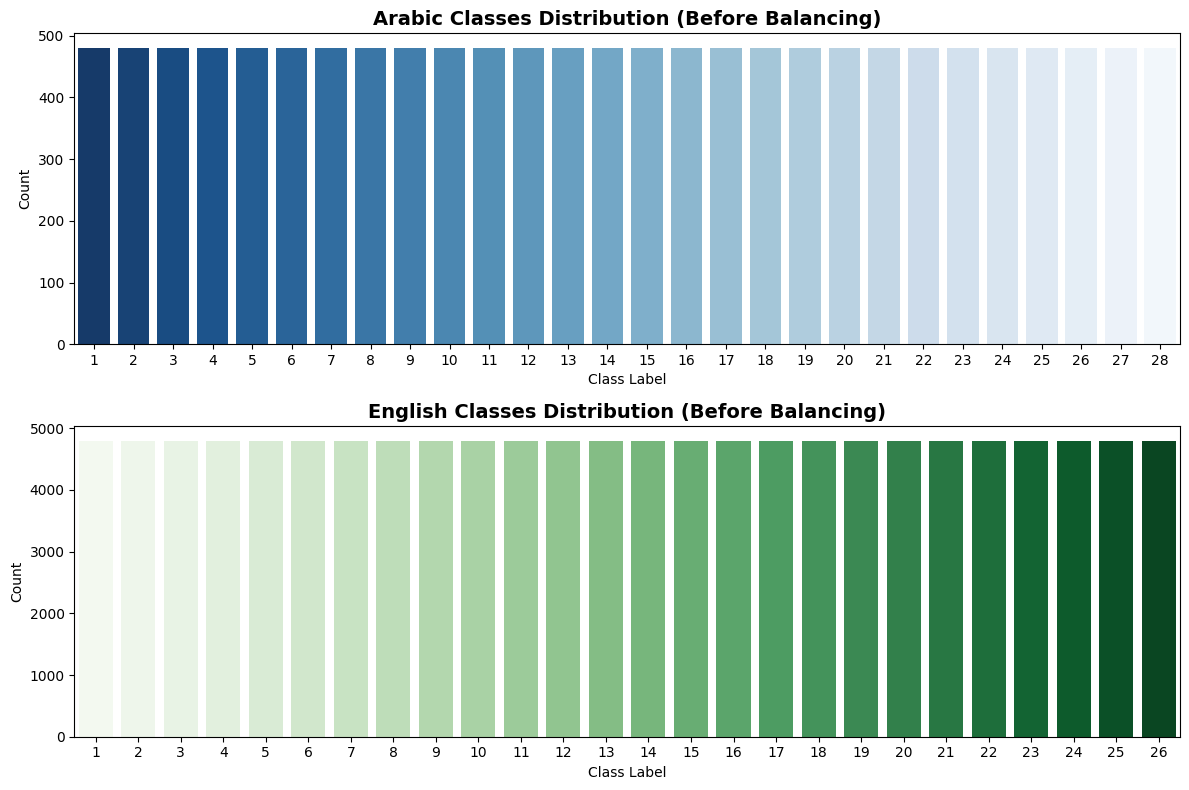

In [4]:
y_labels_arabic = Y_train_arabic.iloc[:, 0]
y_labels_english = y_train_english

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

sns.countplot(x=y_labels_arabic, palette="Blues_r", ax=axes[0])
axes[0].set_title("Arabic Classes Distribution (Before Balancing)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Count")

sns.countplot(x=y_labels_english, palette="Greens", ax=axes[1])
axes[1].set_title("English Classes Distribution (Before Balancing)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [5]:
def balance_dataset(images, labels, samples_per_class, random_state=42):
    np.random.seed(random_state)
    unique_classes = np.unique(labels)
    balanced_images = []
    balanced_labels = []
    
    for class_label in unique_classes:
        class_indices = np.where(labels == class_label)[0]
        
        if len(class_indices) >= samples_per_class:
            selected_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)
        else:
            selected_indices = np.random.choice(class_indices, size=samples_per_class, replace=True)
        
        balanced_images.append(images[selected_indices])
        balanced_labels.append(labels[selected_indices])
    
    balanced_images = np.concatenate(balanced_images, axis=0)
    balanced_labels = np.concatenate(balanced_labels, axis=0)
    
    shuffle_indices = np.random.permutation(len(balanced_labels))
    return balanced_images[shuffle_indices], balanced_labels[shuffle_indices]

print("Balancing English Dataset...")
x_train_english, y_train_english = balance_dataset(x_train_english, y_train_english, 480, random_state=42)
x_test_english, y_test_english = balance_dataset(x_test_english, y_test_english, 120, random_state=42)

print(f"\nBalanced English Dataset:")
print(f"x_train_english: {x_train_english.shape}")
print(f"y_train_english: {y_train_english.shape}")
print(f"x_test_english: {x_test_english.shape}")
print(f"y_test_english: {y_test_english.shape}")


Balancing English Dataset...

Balanced English Dataset:
x_train_english: (12480, 28, 28)
y_train_english: (12480,)
x_test_english: (3120, 28, 28)
y_test_english: (3120,)


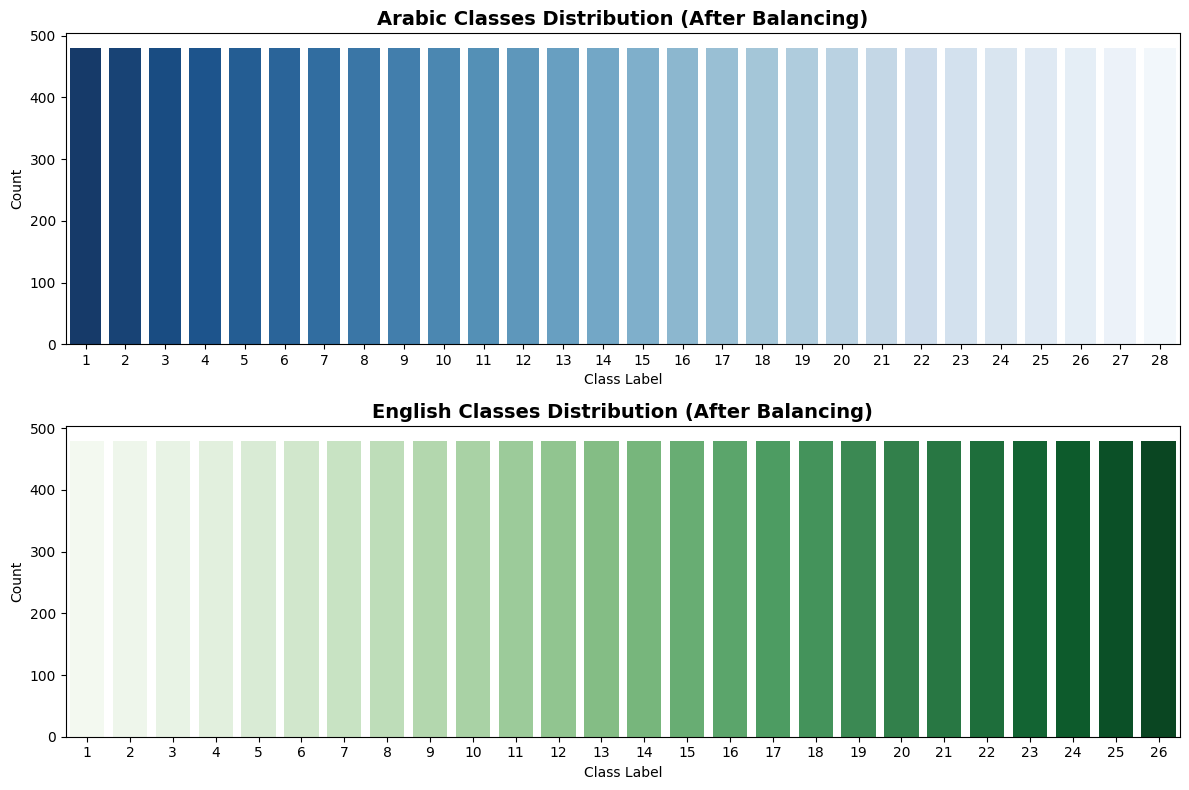

In [6]:
y_labels_arabic = Y_train_arabic.iloc[:, 0]
y_labels_english = y_train_english

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

sns.countplot(x=y_labels_arabic, palette="Blues_r", ax=axes[0])
axes[0].set_title("Arabic Classes Distribution (After Balancing)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Count")

sns.countplot(x=y_labels_english, palette="Greens", ax=axes[1])
axes[1].set_title("English Classes Distribution (After Balancing)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [7]:
def preprocess_images(X, original_size=(32, 32), target_size=(96, 96)):
    if not isinstance(X, np.ndarray):
        X = X.values
    
    # Reshape to (H, W, 1)
    X = X.reshape(-1, original_size[0], original_size[1], 1)
    
    # Resize to 96x96 (ResNet input size)
    X = tf.image.resize(X, target_size).numpy()
    
    # Convert grayscale to RGB
    X = np.repeat(X, 3, axis=-1)
    
    # Vectorized rotation and flip
    X = np.rot90(X, k=-1, axes=(1, 2))
    X = np.flip(X, axis=2)
    
    return X

print("Preprocessing images...")
X_train_arabic = preprocess_images(X_train_arabic, original_size=(32, 32), target_size=(96, 96))
X_test_arabic = preprocess_images(X_test_arabic, original_size=(32, 32), target_size=(96, 96))
x_train_english = preprocess_images(x_train_english, original_size=(28, 28), target_size=(96, 96))
x_test_english = preprocess_images(x_test_english, original_size=(28, 28), target_size=(96, 96))

Y_train_arabic = Y_train_arabic.values.flatten()
Y_test_arabic = Y_test_arabic.values.flatten()

print("\nPreprocessed Dataset Shapes:")
print(f"Arabic Train: {X_train_arabic.shape}, {Y_train_arabic.shape}")
print(f"Arabic Test: {X_test_arabic.shape}, {Y_test_arabic.shape}")
print(f"English Train: {x_train_english.shape}, {y_train_english.shape}")
print(f"English Test: {x_test_english.shape}, {y_test_english.shape}")

Preprocessing images...


I0000 00:00:1765357349.683075      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765357349.683660      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Preprocessed Dataset Shapes:
Arabic Train: (13440, 96, 96, 3), (13440,)
Arabic Test: (3360, 96, 96, 3), (3360,)
English Train: (12480, 96, 96, 3), (12480,)
English Test: (3120, 96, 96, 3), (3120,)


In [8]:
class_mapping = {
    # Arabic (1-28)
    1: "أ", 2: "ب", 3: "ت", 4: "ث", 5: "ج", 6: "ح", 7: "خ", 8: "د", 9: "ذ", 10: "ر",
    11: "ز", 12: "س", 13: "ش", 14: "ص", 15: "ض", 16: "ط", 17: "ظ", 18: "ع", 19: "غ",
    20: "ف", 21: "ق", 22: "ك", 23: "ل", 24: "م", 25: "ن", 26: "هـ", 27: "و", 28: "ي",
    
    # English (29-54)
    29: "A", 30: "B", 31: "C", 32: "D", 33: "E", 34: "F", 35: "G", 36: "H", 37: "I", 38: "J",
    39: "K", 40: "L", 41: "M", 42: "N", 43: "O", 44: "P", 45: "Q", 46: "R", 47: "S", 48: "T",
    49: "U", 50: "V", 51: "W", 52: "X", 53: "Y", 54: "Z"
}

print(f"Total classes: {len(class_mapping)}")

Total classes: 54



Remapping English labels from 1-26 to 29-54...

Combined Dataset:
X_train: (25920, 96, 96, 3), Y_train: (25920,)
X_test: (6480, 96, 96, 3), Y_test: (6480,)
Label range: 1 to 54


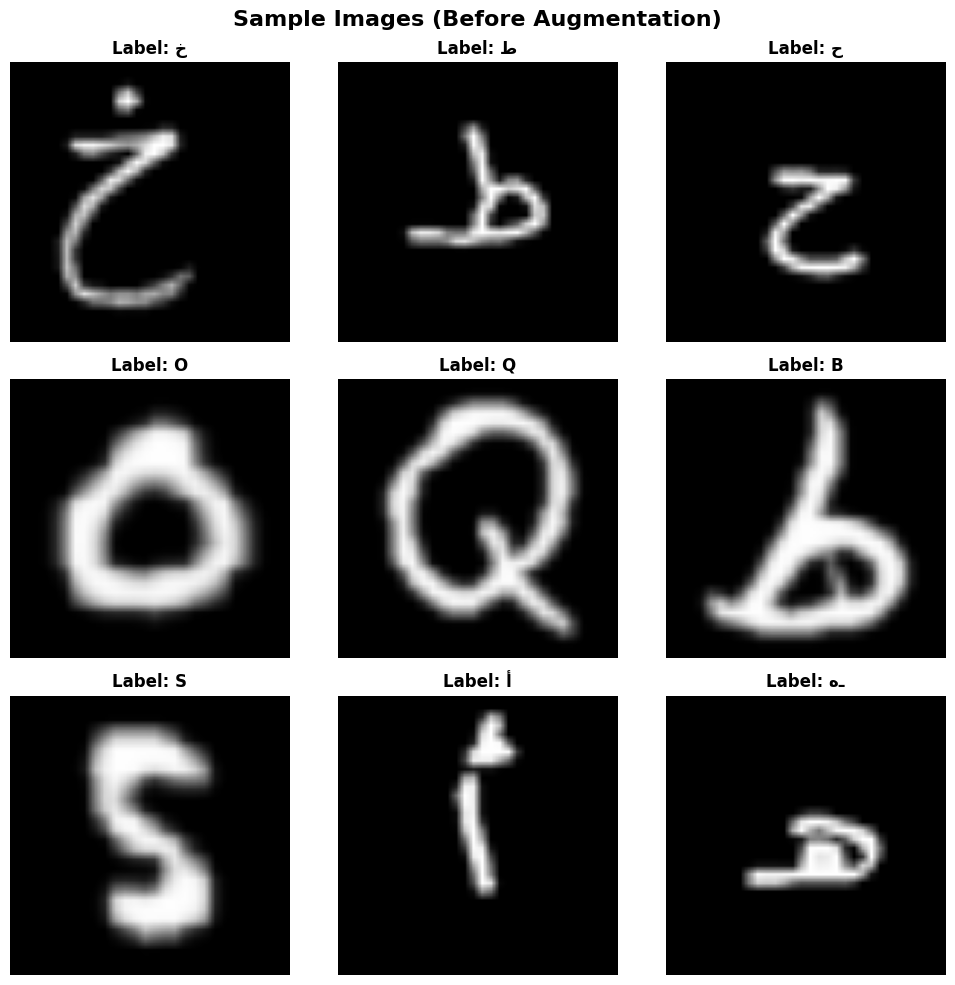

In [9]:
def visualize_samples(X, Y, class_mapping, title="Sample Images"):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    
    for ax in axes:
        idx = np.random.randint(0, len(X))
        img = X[idx].astype('uint8')
        label = class_mapping[Y[idx]]
        
        ax.imshow(img)
        ax.set_title(f"Label: {label}", fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Remap English labels from 1-26 to 29-54
print("\nRemapping English labels from 1-26 to 29-54...")
y_train_english = y_train_english + 28
y_test_english = y_test_english + 28

# Combine datasets
X_train = np.concatenate([X_train_arabic, x_train_english], axis=0)
Y_train = np.concatenate([Y_train_arabic, y_train_english], axis=0)
X_test = np.concatenate([X_test_arabic, x_test_english], axis=0)
Y_test = np.concatenate([Y_test_arabic, y_test_english], axis=0)

print(f"\nCombined Dataset:")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")
print(f"Label range: {Y_train.min()} to {Y_train.max()}")

visualize_samples(X_train, Y_train, class_mapping, "Sample Images (Before Augmentation)")


Creating augmented training dataset...
Generating 25,920 augmented samples...
Progress: 50/202 batches (24.8%)
Progress: 100/202 batches (49.5%)
Progress: 150/202 batches (74.3%)
Progress: 200/202 batches (99.0%)
Concatenating batches...

Augmented Training Data:
X_train_augmented: (25856, 96, 96, 3)
Y_train_augmented: (25856,)


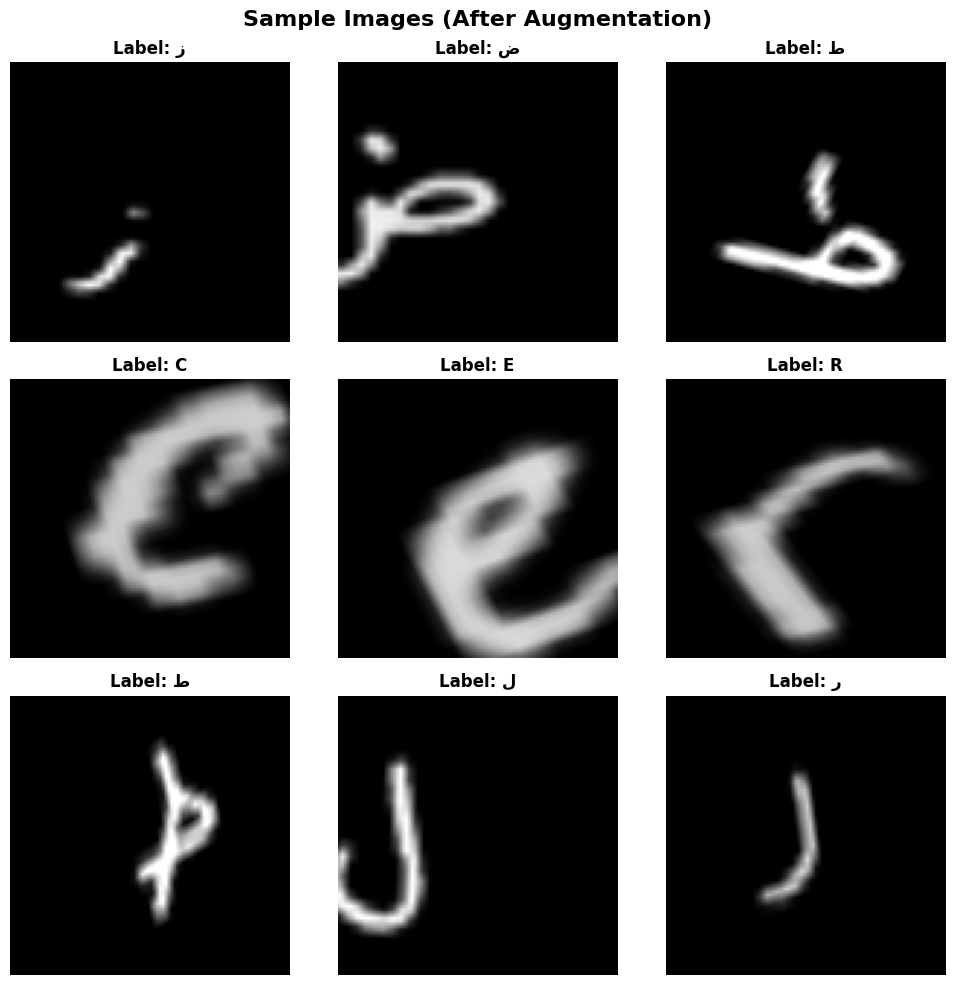

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def add_noise(image):
    noise = np.random.normal(0, 10, image.shape)
    image = image + noise
    return np.clip(image, 0, 255)

print("Creating augmented training dataset...")

# Data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Generate augmented samples
datagen.fit(X_train)
augmentation_factor = 1

batch_size = 128
augmented_images = []
augmented_labels = []

total_samples = len(X_train) * augmentation_factor
batches = 0
total_batches = total_samples // batch_size

print(f"Generating {total_samples:,} augmented samples...")

for X_batch, Y_batch in datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=False):
    augmented_images.append(X_batch)
    augmented_labels.append(Y_batch)
    batches += 1
    
    if batches % 50 == 0:
        print(f"Progress: {batches}/{total_batches} batches ({(batches/total_batches)*100:.1f}%)")
    
    if batches >= total_batches:
        break

# Efficient concatenation
print("Concatenating batches...")
X_train_augmented = np.vstack(augmented_images)
Y_train_augmented = np.concatenate(augmented_labels)

print(f"\nAugmented Training Data:")
print(f"X_train_augmented: {X_train_augmented.shape}")
print(f"Y_train_augmented: {Y_train_augmented.shape}")

visualize_samples(X_train_augmented, Y_train_augmented, class_mapping, 
                 "Sample Images (After Augmentation)")


In [11]:
from tensorflow.keras.applications.resnet50 import preprocess_input

print("Preparing data for ResNet50...")

# Convert to 0-indexed labels
num_classes = 54
Y_train_sparse = Y_train_augmented.astype(int) - 1  # 1-54 to 0-53
Y_test_sparse = Y_test.astype(int) - 1

# Shuffle training data
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
Y_train_sparse = Y_train_sparse[shuffle_idx]

# Preprocess for ResNet50
X_train_processed = preprocess_input(X_train_augmented.copy())
X_test_processed = preprocess_input(X_test.copy())

print(f"X_train_processed: {X_train_processed.shape}")
print(f"Y_train_sparse: {Y_train_sparse.shape}")
print(f"X_test_processed: {X_test_processed.shape}")
print(f"Y_test_sparse: {Y_test_sparse.shape}")
print(f"Label range: {Y_train_sparse.min()} to {Y_train_sparse.max()}")


Preparing data for ResNet50...
X_train_processed: (25856, 96, 96, 3)
Y_train_sparse: (25856,)
X_test_processed: (6480, 96, 96, 3)
Y_test_sparse: (6480,)
Label range: 0 to 53


In [12]:
from sklearn.model_selection import train_test_split

X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train_processed, 
    Y_train_sparse,
    test_size=0.15,
    random_state=42,
    stratify=Y_train_sparse
)

print(f"Training set: {X_train_final.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_processed.shape}")

Training set: (21977, 96, 96, 3)
Validation set: (3879, 96, 96, 3)
Test set: (6480, 96, 96, 3)


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_resnet_model(input_shape=(96, 96, 3), num_classes=54):
    base_model = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', name='dense_512')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', name='dense_256')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', name='dense_layer')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

print("Building ResNet50 model...")
model, base_model = build_resnet_model(num_classes=num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

model.summary()


Building ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Total parameters: 24,847,798
Trainable parameters: 1,260,086


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 24,847,798 (94.79 MB)

 Trainable params: 1,260,086 (4.81 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

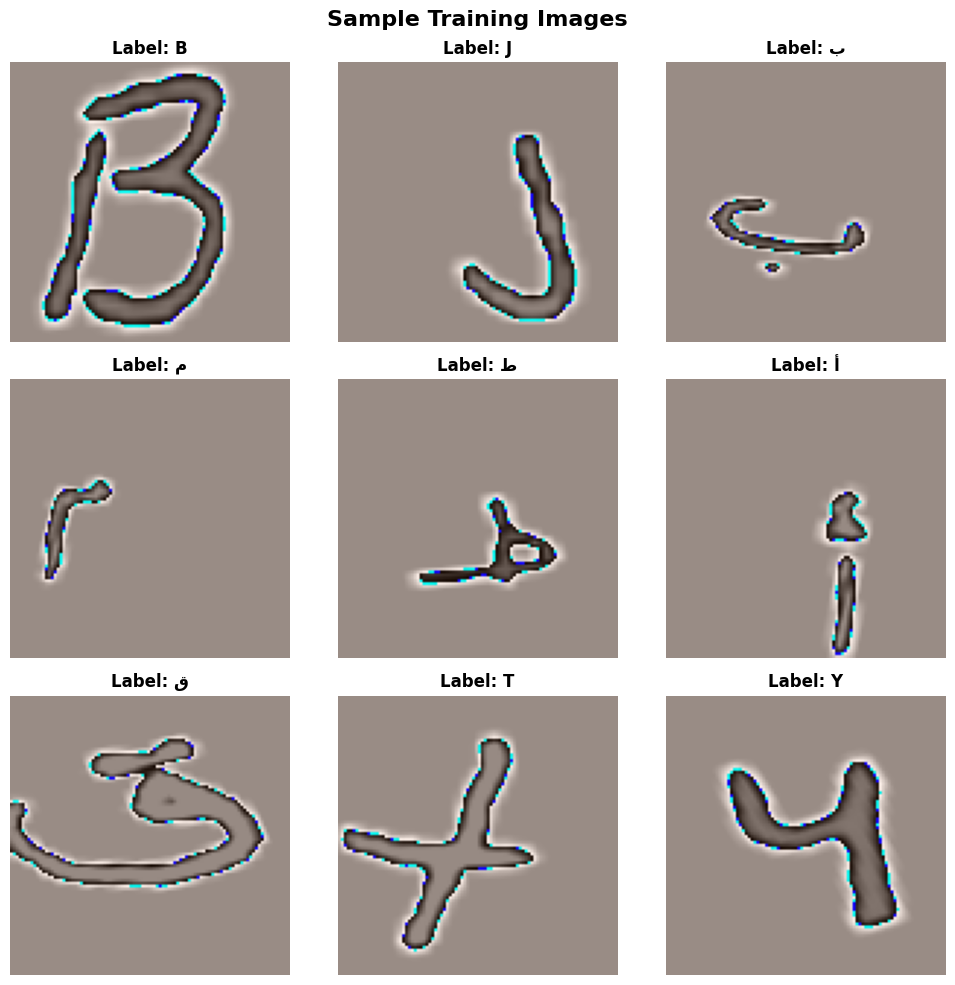

In [14]:
visualize_samples(X_train_final, Y_train_final + 1, class_mapping, 
                 "Sample Training Images")


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_resnet50_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

print("Starting training...")
history = model.fit(
    X_train_final,
    Y_train_final,
    batch_size=64,
    epochs=20,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")


Starting training...
Epoch 1/20


I0000 00:00:1765357439.659188     109 service.cc:148] XLA service 0x7aab8c091d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765357439.660105     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765357439.660126     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765357441.205956     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/344 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.0408 - loss: 4.9022 

I0000 00:00:1765357446.045407     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5837 - loss: 1.3082
Epoch 6: val_accuracy improved from 0.63625 to 0.65584, saving model to best_resnet50_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.5837 - loss: 1.3083 - val_accuracy: 0.6558 - val_loss: 1.1020 - learning_rate: 0.0010
Epoch 7/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6038 - loss: 1.2523
Epoch 7: val_accuracy improved from 0.65584 to 0.66254, saving model to best_resnet50_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.6038 - loss: 1.2523 - val_accuracy: 0.6625 - val_loss: 1.0599 - learning_rate: 0.0010
Epoch 8/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6245 - loss: 1.1905
Epoch 8: val_accuracy did not improve from 0.66254
344/344 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.6245 - loss: 1.1905 - val_accuracy: 0.6592 - val_loss: 1.0372 - learning_rate: 0.0010
Epoch 9/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6346 - loss: 1.1413
Epoch 9: val_accuracy improved from 0.66254 to 0.68497, saving model to best_resnet50_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6346 - loss: 1.1413 - val_accuracy: 0.6850 - val_loss: 0.9998 - learning_rate: 0.0010
Epoch 10/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6489 - loss: 1.0959
Epoch 10: val_accuracy did not improve from 0.68497
344/344 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.6489 - loss: 1.0959 - val_accuracy: 0.6783 - val_loss: 1.0065 - learning_rate: 0.0010
Epoch 11/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6627 - loss: 1.0569
Epoch 11: val_accuracy improved from 0.68497 to 0.69734, saving model to best_resnet50_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.6626 - loss: 1.0570 - val_accuracy: 0.6973 - val_loss: 0.9861 - learning_rate: 0.0010
Epoch 12/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6766 - loss: 1.0101
Epoch 12: val_accuracy improved from 0.69734 to 0.69863, saving model to best_resnet50_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6766 - loss: 1.0102 - val_accuracy: 0.6986 - val_loss: 0.9448 - learning_rate: 0.0010
Epoch 13/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6862 - loss: 0.9807
Epoch 13: val_accuracy did not improve from 0.69863
344/344 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.6862 - loss: 0.9808 - val_accuracy: 0.6979 - val_loss: 0.9695 - learning_rate: 0.0010
Epoch 14/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6877 - loss: 0.9574
Epoch 14: val_accuracy improved from 0.69863 to 0.71075, saving model to best_resnet50_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6877 - loss: 0.9575 - val_accuracy: 0.7108 - val_loss: 0.9478 - learning_rate: 0.0010
Epoch 15/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7021 - loss: 0.9150
Epoch 15: val_accuracy improved from 0.71075 to 0.72106, saving model to best_resnet50_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.7021 - loss: 0.9151 - val_accuracy: 0.7211 - val_loss: 0.9213 - learning_rate: 0.0010
Epoch 16/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7123 - loss: 0.8877
Epoch 16: val_accuracy did not improve from 0.72106
344/344 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7123 - loss: 0.8878 - val_accuracy: 0.7059 - val_loss: 0.9550 - learning_rate: 0.0010
Epoch 17/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7147 - loss: 0.8733
Epoch 17: val_accuracy did not improve from 0.72106
344/344 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7146 - loss: 0.8734 - val_accuracy: 0.7141 - val_loss: 0.9224 - learning_rate: 0.0010
Epoch 18/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7218 - loss: 0.8498
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: val_accuracy did not improve from 0.72106
344/344 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7218 - loss: 0.8

344/344 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.7514 - loss: 0.7530 - val_accuracy: 0.7309 - val_loss: 0.8911 - learning_rate: 5.0000e-04
Epoch 20/20
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7704 - loss: 0.6919
Epoch 20: val_accuracy improved from 0.73086 to 0.73911, saving model to best_resnet50_model.h5


344/344 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.7705 - loss: 0.6918 - val_accuracy: 0.7391 - val_loss: 0.8669 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 20.

Training completed!


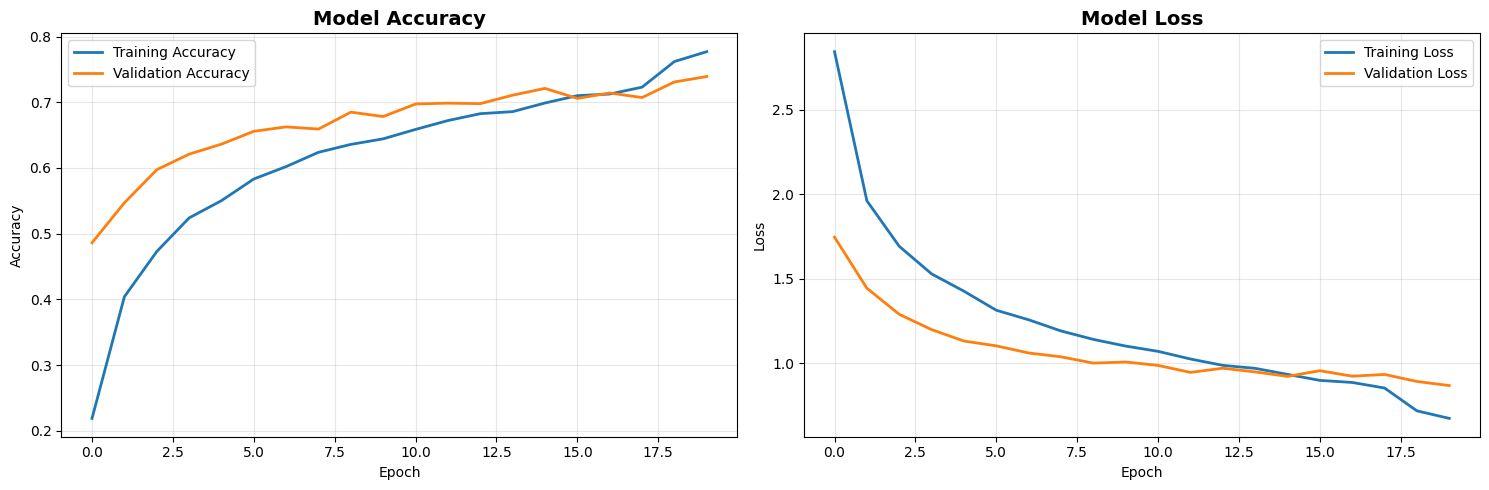

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
test_loss, test_accuracy = model.evaluate(X_test_processed, Y_test_sparse, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.6071
Test Accuracy: 81.20%


Generating predictions on test set...


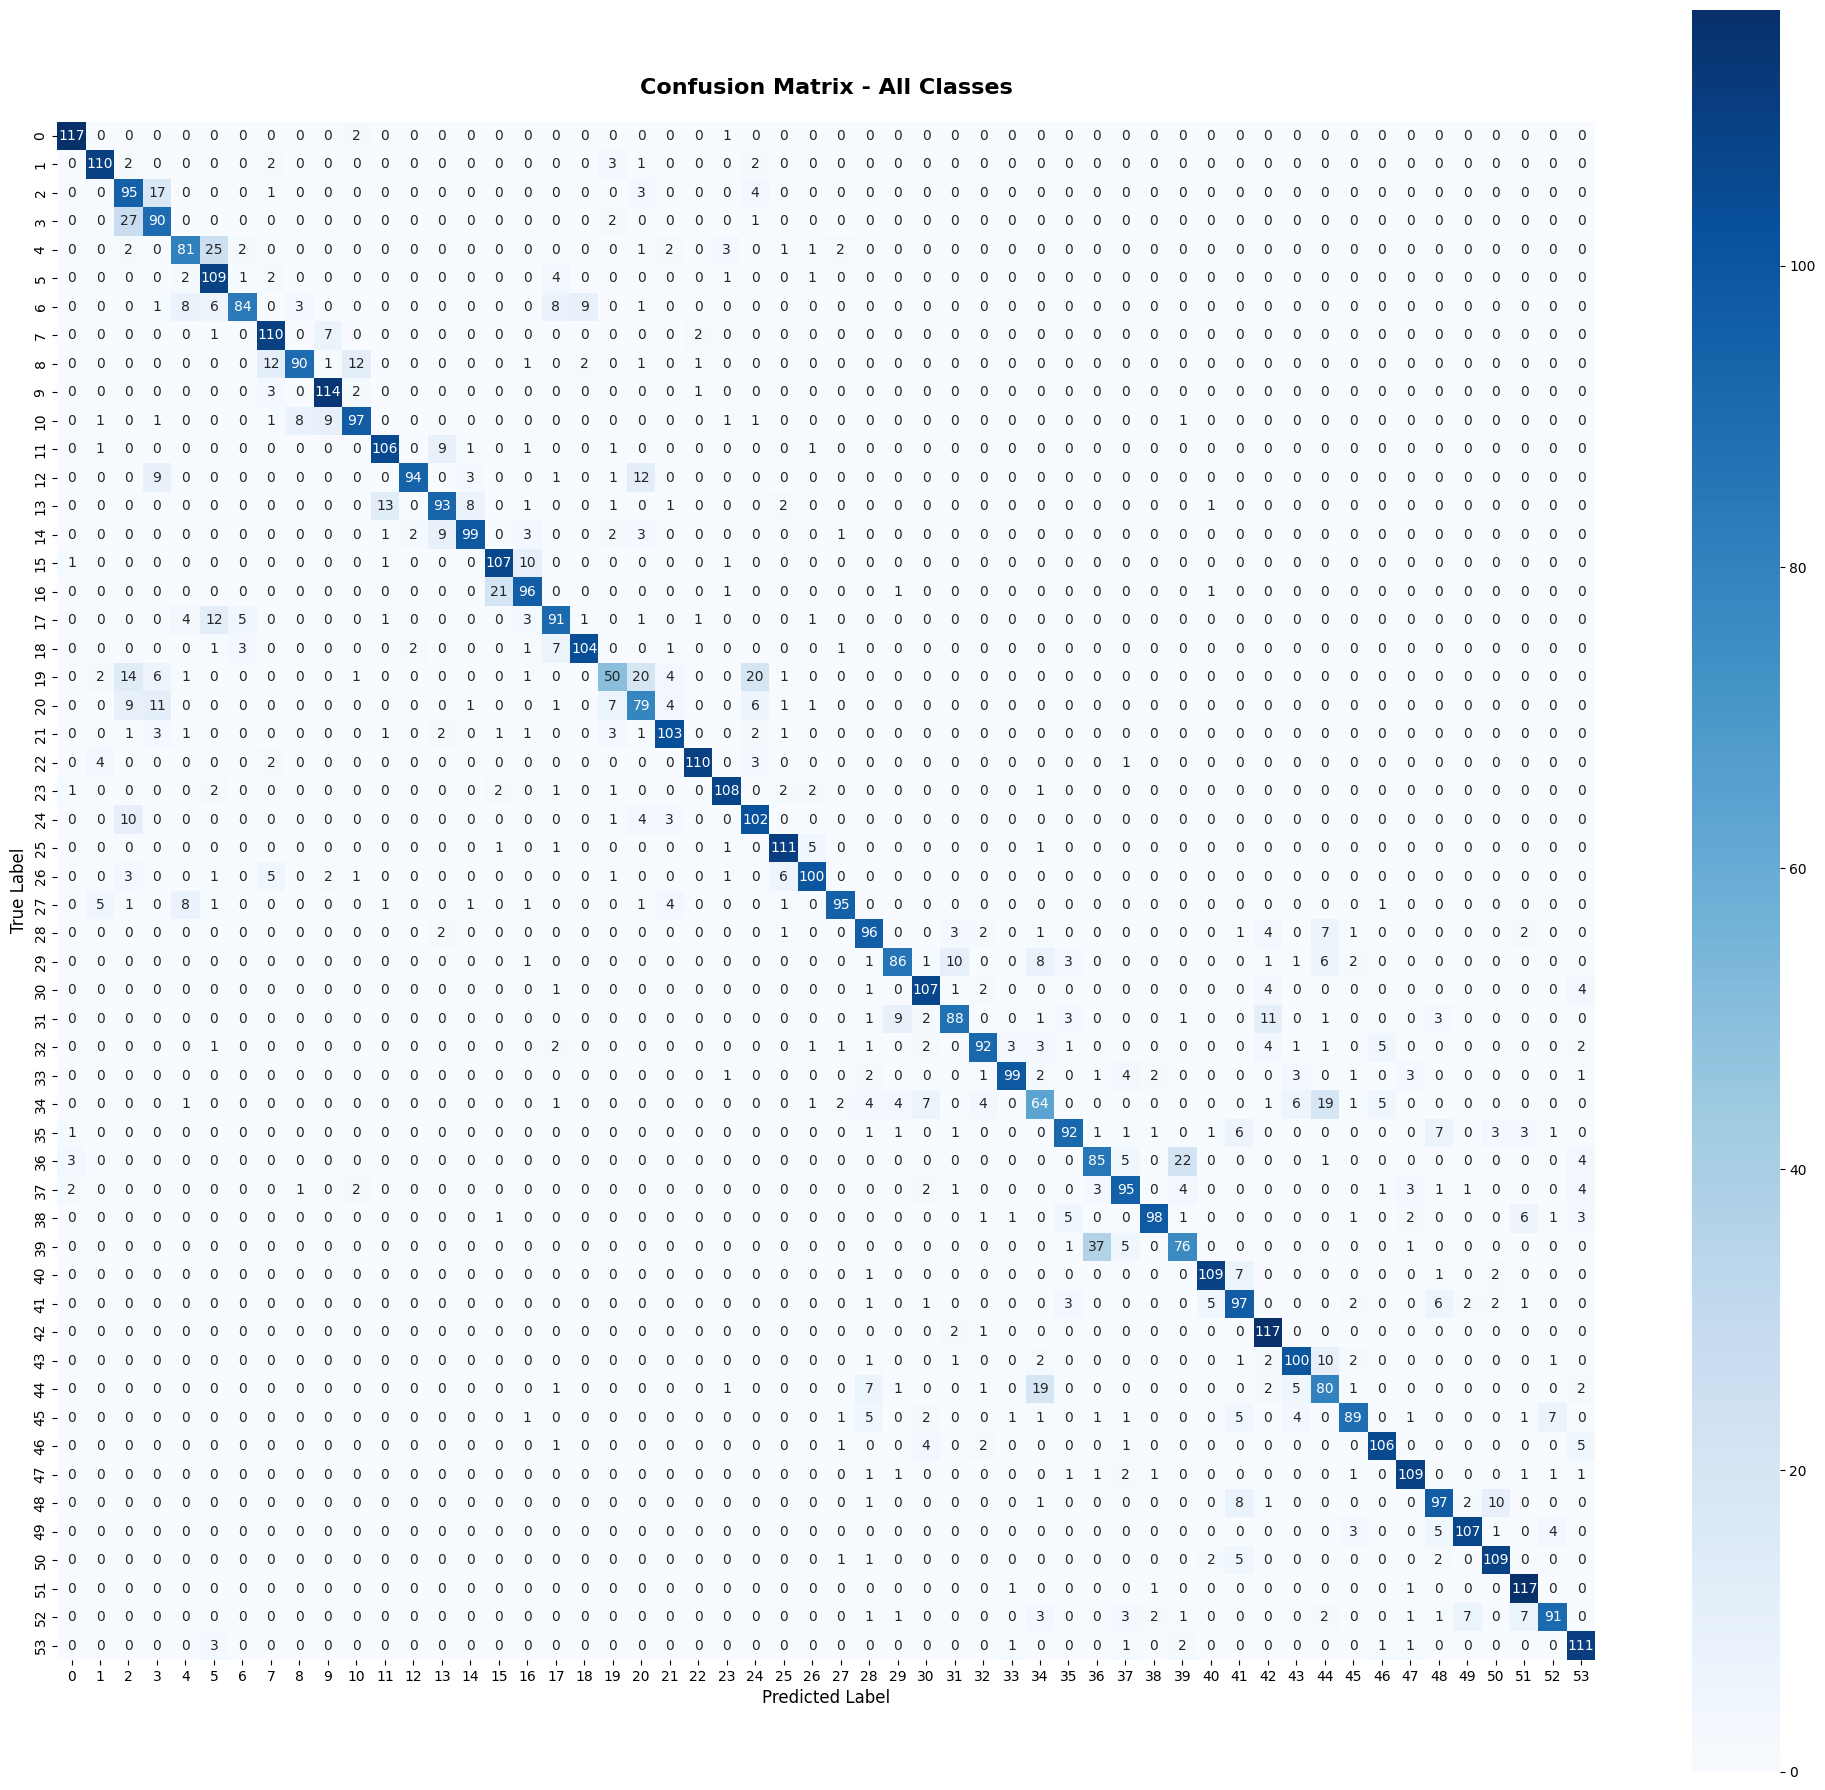

In [18]:
print("Generating predictions on test set...")
Y_pred_probs = model.predict(X_test_processed, verbose=0)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(Y_test_sparse, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)
plt.title('Confusion Matrix - All Classes', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


In [19]:
per_class_acc = []
for i in range(num_classes):
    mask = Y_test_sparse == i
    if np.sum(mask) > 0:
        acc = np.mean(Y_pred[mask] == i)
        per_class_acc.append((class_mapping[i+1], acc, np.sum(mask)))

per_class_acc.sort(key=lambda x: x[1])

print("\nTop 10 Best Performing Classes:")
print(f"{'Class':<10} {'Accuracy':<12} {'Samples':<10}")
print("-" * 35)
for char, acc, count in per_class_acc[-10:]:
    print(f"{char:<10} {acc*100:>6.2f}%      {count:<10}")

print("\nTop 10 Worst Performing Classes:")
print(f"{'Class':<10} {'Accuracy':<12} {'Samples':<10}")
print("-" * 35)
for char, acc, count in per_class_acc[:10]:
    print(f"{char:<10} {acc*100:>6.2f}%      {count:<10}")


Top 10 Best Performing Classes:
Class      Accuracy     Samples   
-----------------------------------
W           90.83%      120       
ب           91.67%      120       
د           91.67%      120       
ل           91.67%      120       
هـ          92.50%      120       
Z           92.50%      120       
ر           95.00%      120       
أ           97.50%      120       
O           97.50%      120       
X           97.50%      120       

Top 10 Worst Performing Classes:
Class      Accuracy     Samples   
-----------------------------------
ف           41.67%      120       
G           53.33%      120       
L           63.33%      120       
ق           65.83%      120       
Q           66.67%      120       
ج           67.50%      120       
خ           70.00%      120       
I           70.83%      120       
B           71.67%      120       
D           73.33%      120       


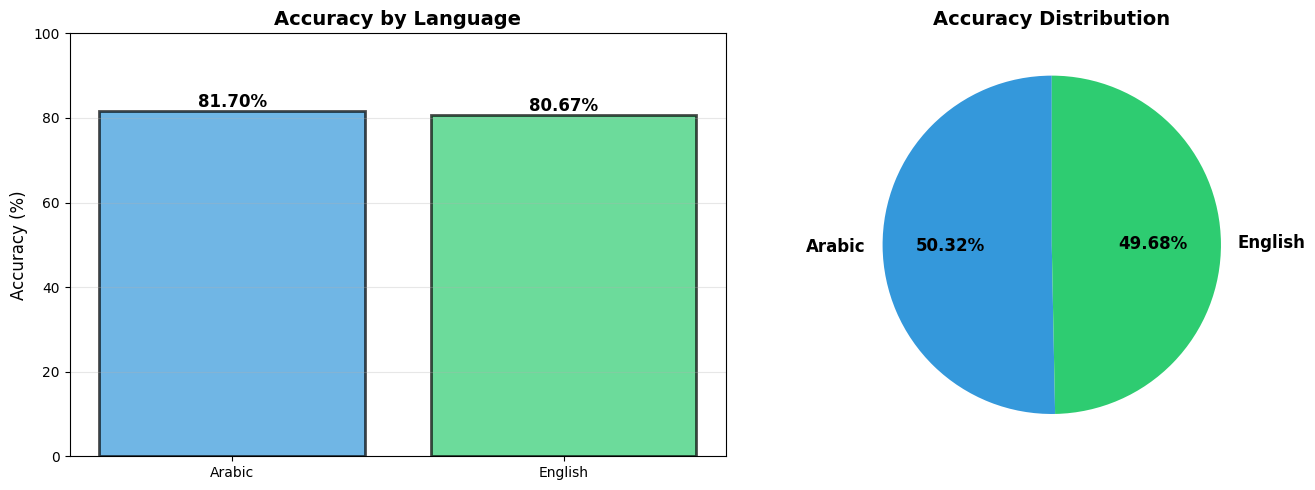


Arabic Characters Accuracy: 81.70%
English Characters Accuracy: 80.67%
Overall Test Accuracy: 81.20%


In [20]:
arabic_indices = Y_test_sparse < 28  # Classes 0-27 (Arabic)
english_indices = Y_test_sparse >= 28  # Classes 28-53 (English)

arabic_acc = np.mean(Y_pred[arabic_indices] == Y_test_sparse[arabic_indices])
english_acc = np.mean(Y_pred[english_indices] == Y_test_sparse[english_indices])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
languages = ['Arabic', 'English']
accuracies = [arabic_acc * 100, english_acc * 100]
colors = ['#3498db', '#2ecc71']

bars = ax1.bar(languages, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy by Language', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Pie chart
ax2.pie(accuracies, labels=languages, autopct='%1.2f%%', startangle=90,
        colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Accuracy Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nArabic Characters Accuracy: {arabic_acc*100:.2f}%")
print(f"English Characters Accuracy: {english_acc*100:.2f}%")
print(f"Overall Test Accuracy: {test_accuracy*100:.2f}%")


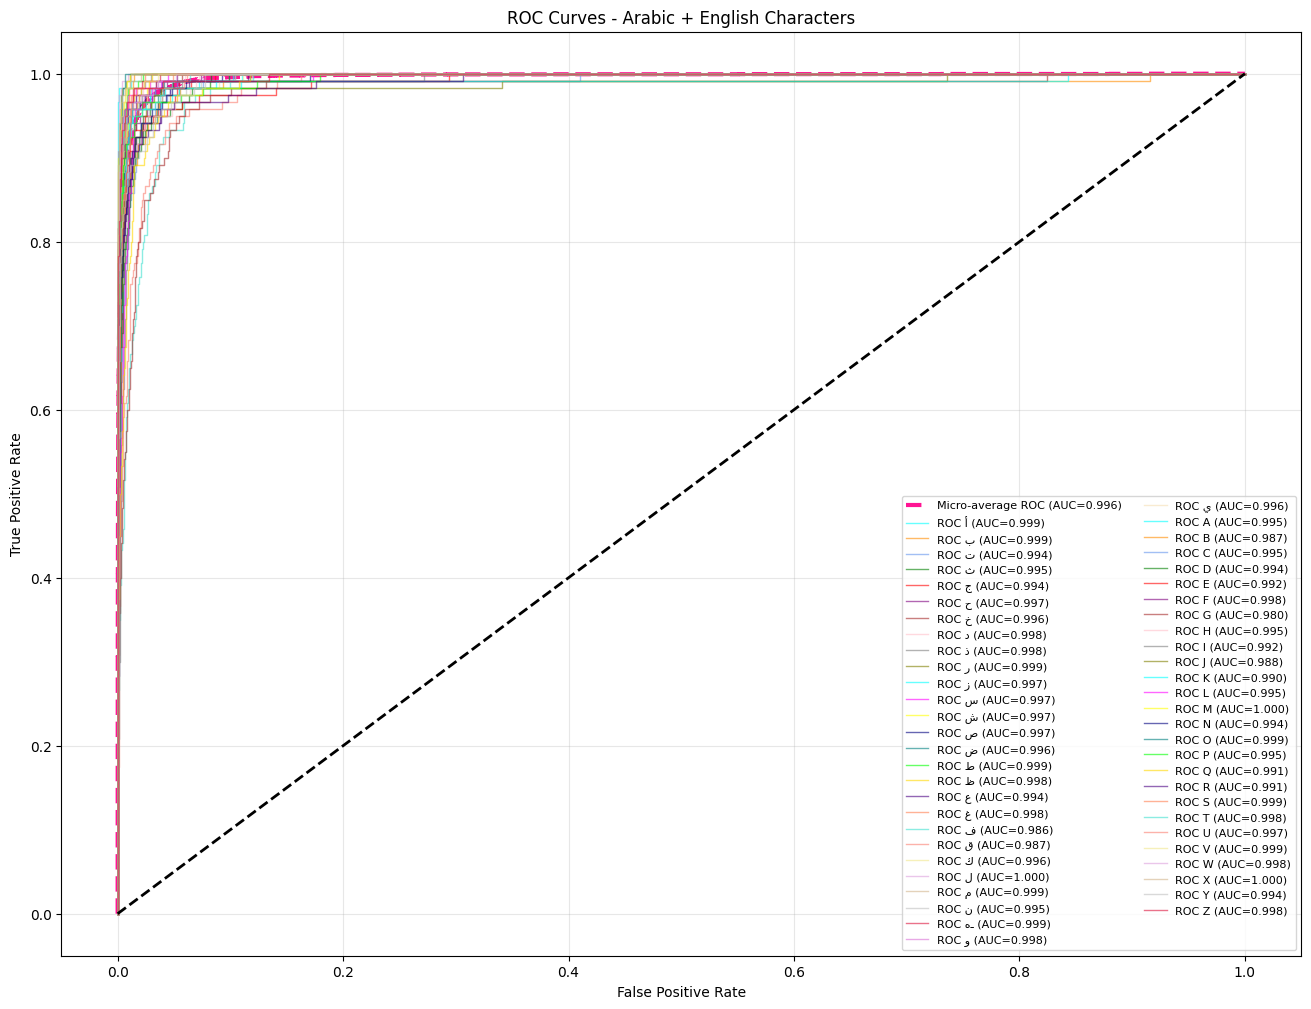

KeyError: 0

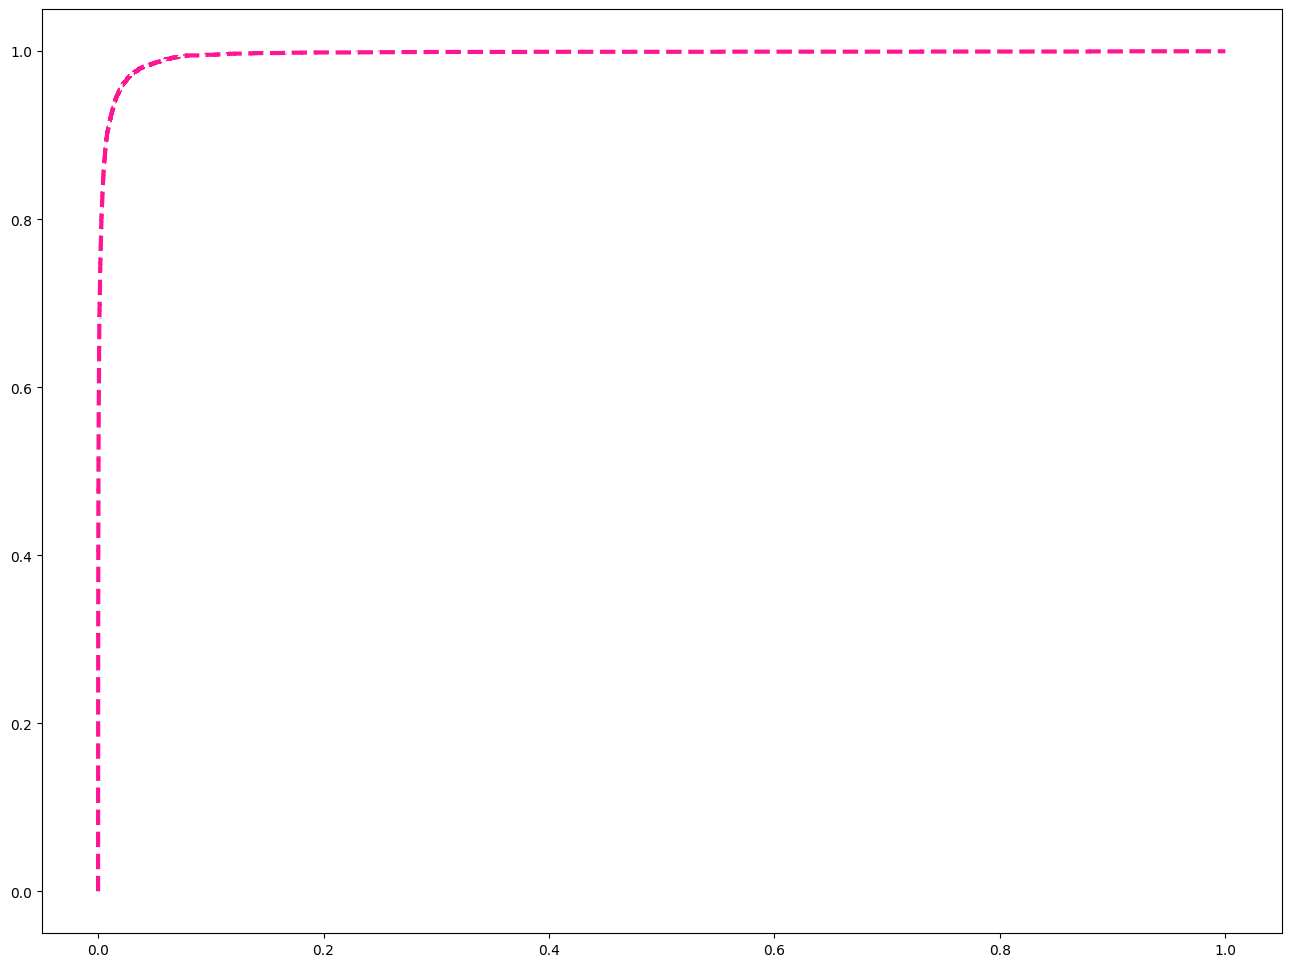

In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from itertools import cycle
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ROC & AUC
Y_test_bin = label_binarize(Y_test_sparse, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(16, 12))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC={roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=3)

colors = cycle([
    'aqua','darkorange','cornflowerblue','green','red','purple',
    'brown','pink','gray','olive','cyan','magenta','yellow',
    'navy','teal','lime','gold','indigo','coral','turquoise',
    'salmon','khaki','plum','tan','silver','crimson','orchid','wheat'
])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.6,
             label=f'ROC {class_list[i]} (AUC={roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Arabic + English Characters')
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.show()

# ROC & AUC
Y_test_bin = label_binarize(Y_test_sparse+1, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(16, 12))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC={roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=3)

colors = cycle(['aqua','darkorange','cornflowerblue','green','red','purple',
                'brown','pink','gray','olive','cyan','magenta','yellow',
                'navy','teal','lime','gold','indigo','coral','turquoise',
                'salmon','khaki','plum','tan','silver','crimson','orchid','wheat'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.6,
             label=f'ROC {class_names[i]} (AUC={roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Arabic Characters')
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.show()


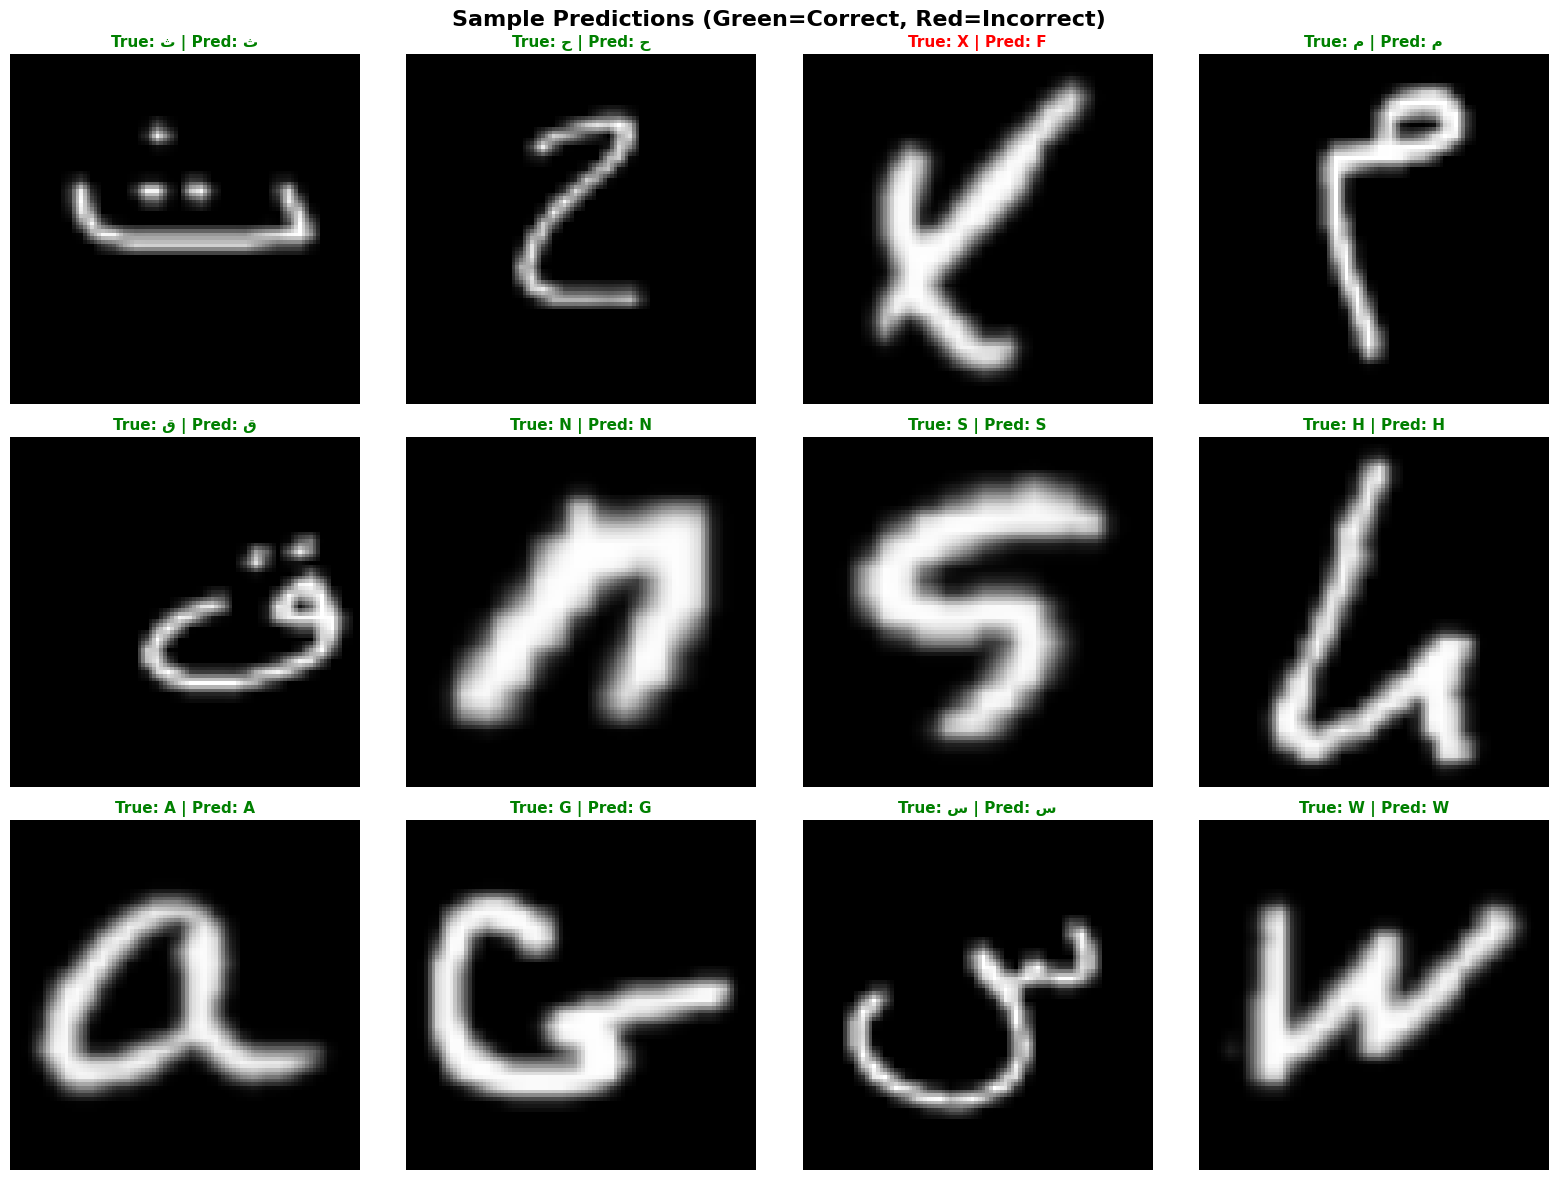

In [23]:
def visualize_predictions(X_processed, X_original, Y_true, Y_pred, class_mapping, num_samples=12):
    num_rows = 3
    num_cols = 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))
    axes = axes.flatten()
    
    indices = np.random.choice(len(X_processed), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Use ORIGINAL image for display (not preprocessed)
        img = X_original[idx].astype('uint8')
        
        true_label = class_mapping[Y_true[idx] + 1]
        pred_label = class_mapping[Y_pred[idx] + 1]
        
        color = 'green' if Y_true[idx] == Y_pred[idx] else 'red'
        
        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_label} | Pred: {pred_label}',
                         color=color, fontsize=11, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Use ORIGINAL test images for visualization
visualize_predictions(X_test_processed, X_test, Y_test_sparse, Y_pred, class_mapping)

In [29]:
from sklearn.metrics import classification_report

class_list = [
    "أ", "ب", "ت", "ث", "ج", "ح", "خ", "د", "ذ", "ر",
    "ز", "س", "ش", "ص", "ض", "ط", "ظ", "ع", "غ",
    "ف", "ق", "ك", "ل", "م", "ن", "هـ", "و", "ي",
    "A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
    "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T",
    "U", "V", "W", "X", "Y", "Z"
]

# classification report
report = classification_report(Y_test_sparse, Y_pred, target_names=class_list)
print("CLASSIFICATION REPORT")
print("="*70)
print(report)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           أ       0.94      0.97      0.96       120
           ب       0.89      0.92      0.91       120
           ت       0.58      0.79      0.67       120
           ث       0.65      0.75      0.70       120
           ج       0.76      0.68      0.72       120
           ح       0.67      0.91      0.77       120
           خ       0.88      0.70      0.78       120
           د       0.80      0.92      0.85       120
           ذ       0.88      0.75      0.81       120
           ر       0.86      0.95      0.90       120
           ز       0.83      0.81      0.82       120
           س       0.85      0.88      0.87       120
           ش       0.96      0.78      0.86       120
           ص       0.81      0.78      0.79       120
           ض       0.88      0.82      0.85       120
           ط       0.80      0.89      0.85       120
           ظ       0.79      0.80      0.80       120
     